## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [5]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sat Mar 30 18:42:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   34C    P8    N/A /  N/A |    331MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
from numba import cuda
import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

cuda.select_device(0)
cuda.close()
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
def build_mlp(drop_ratio, input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64, 32, 16]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(input_layer)
            x = keras.layers.Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
            x = keras.layers.Dropout(drop_ratio)(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [16]:
## 超參數設定
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
EPOCHS = 50
BATCH_SIZE = 256

N_LAYERS = [4, 5, 6]
DROPOUT = [0.1, 0.2, 0.3, 0.4]

In [17]:
def model_fitting(drop_ratio, n_layers, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):
    
    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    
    model = build_mlp(drop_ratio=drop_ratio, n_layers=n_layers, input_shape=input_shape)
    model.summary()
    
    switcher = {'sgd': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'rmsp': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'adag': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    optimizer = switcher.get(optimizer)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=False,
                        verbose=2)
    
    sess.close()

    return history

In [18]:
results = {}

for drop_ratio, n_layers in itertools.product(DROPOUT, N_LAYERS):
    
    history = model_fitting(drop_ratio=drop_ratio, n_layers=n_layers)
    
    name_tag = f'DR={drop_ratio}, {n_layers} layers'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Epoch 5/50
 - 4s - loss: 1.7026 - acc: 0.3906 - val_loss: 1.6235 - val_acc: 0.4218
Epoch 6/50
 - 4s - loss: 1.6664 - acc: 0.4056 - val_loss: 1.5741 - val_acc: 0.4431
Epoch 7/50
 - 4s - loss: 1.6417 - acc: 0.4126 - val_loss: 1.5605 - val_acc: 0.4439
Epoch 8/50
 - 5s - loss: 1.6101 - acc: 0.4234 - val_loss: 1.5329 - val_acc: 0.4489
Epoch 9/50
 - 5s - loss: 1.5899 - acc: 0.4324 - val_loss: 1.5198 - val_acc: 0.4527
Epoch 10/50
 - 5s - loss: 1.5765 - acc: 0.4374 - val_loss: 1.5137 - val_acc: 0.4566
Epoch 11/50
 - 4s - loss: 1.5641 - acc: 0.4411 - val_loss: 1.5145 - val_acc: 0.4630
Epoch 12/50
 - 5s - loss: 1.5397 - acc: 0.4500 - val_loss: 1.4846 - val_acc: 0.4729
Epoch 13/50
 - 5s - loss: 1.5326 - acc: 0.4541 - val_loss: 1.4649 - val_acc: 0.4824
Epoch 14/50
 - 5s - loss: 1.5213 - acc: 0.4569 - val_loss: 1.4800 - val_acc: 0.4790
Epoch 15/50
 - 4s - loss: 1.5078 - acc: 0.4639 - val_loss: 1.4916 - val_acc: 0.4701
Epoch 16/50
 - 4s - loss: 1.4969 - acc: 0.4667 - val_loss: 1.4696 - val_acc: 0.47

 - 4s - loss: 1.4807 - acc: 0.4762 - val_loss: 1.4519 - val_acc: 0.4835
Epoch 27/50
 - 4s - loss: 1.4696 - acc: 0.4823 - val_loss: 1.4641 - val_acc: 0.4838
Epoch 28/50
 - 4s - loss: 1.4673 - acc: 0.4823 - val_loss: 1.4437 - val_acc: 0.4900
Epoch 29/50
 - 4s - loss: 1.4535 - acc: 0.4899 - val_loss: 1.4447 - val_acc: 0.4917
Epoch 30/50
 - 4s - loss: 1.4536 - acc: 0.4857 - val_loss: 1.4416 - val_acc: 0.4903
Epoch 31/50
 - 4s - loss: 1.4453 - acc: 0.4903 - val_loss: 1.4300 - val_acc: 0.4962
Epoch 32/50
 - 4s - loss: 1.4377 - acc: 0.4918 - val_loss: 1.4388 - val_acc: 0.4922
Epoch 33/50
 - 4s - loss: 1.4396 - acc: 0.4907 - val_loss: 1.4438 - val_acc: 0.4914
Epoch 34/50
 - 4s - loss: 1.4210 - acc: 0.4952 - val_loss: 1.4409 - val_acc: 0.4838
Epoch 35/50
 - 4s - loss: 1.4227 - acc: 0.4995 - val_loss: 1.4214 - val_acc: 0.4980
Epoch 36/50
 - 4s - loss: 1.4140 - acc: 0.5006 - val_loss: 1.4178 - val_acc: 0.5029
Epoch 37/50
 - 4s - loss: 1.4091 - acc: 0.5021 - val_loss: 1.4213 - val_acc: 0.5054
Epoc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 6s - loss: 2.1558 - acc: 0.1764 - val_loss: 1.9963 - val_acc: 0.2439
Epoch 2/50
 - 4s - loss: 1.9890 - acc: 0.2463 - val_loss: 1.8922 - val_acc: 0.2999
Epoch 3/50
 - 4s - loss: 1.9307 - acc: 0.2741 - val_loss: 1.8253 - val_acc: 0.3298
Epoch 4/50
 - 4s - loss: 1.8925 - acc: 0.2965 - val_loss: 1.7789 - val_acc: 0.3526
Epoch 5/50
 - 4s - loss: 1.8543 - acc: 0.3181 - val_loss: 1.7623 - val_acc: 0.3673
Epoch 6/50
 - 5s - loss: 1.8340 - acc: 0.3294 - val_loss: 1.7406 - val_acc: 0.3723
Epoch 7/50
 - 4s - loss: 1.8101 - acc: 0.3374 - val_loss: 1.7019 - val_acc: 0.3938
Epoch 8/50
 - 4s - loss: 1.7841 - acc: 0.3510 - val_loss: 1.6900 - val_acc: 0.3929
Epoch 9/50
 - 4s - loss: 1.7687 - acc: 0.3583 - val_loss: 1.7097 - val_acc: 0.3845
Epoch 10/50
 - 4s - loss: 1.7538 - acc: 0.3651 - val_loss: 1.6576 - val_acc: 0.4068
Epoch 11/50
 - 4s - loss: 1.7418 - acc: 0.3694 - val_loss: 1.6617 - val_acc: 0.4024
Epoch 12/50
 - 4s - loss: 1.7354 - 

Epoch 22/50
 - 4s - loss: 1.7961 - acc: 0.3382 - val_loss: 1.7280 - val_acc: 0.3707
Epoch 23/50
 - 4s - loss: 1.7882 - acc: 0.3401 - val_loss: 1.7310 - val_acc: 0.3749
Epoch 24/50
 - 4s - loss: 1.7824 - acc: 0.3427 - val_loss: 1.6909 - val_acc: 0.3901
Epoch 25/50
 - 4s - loss: 1.7759 - acc: 0.3482 - val_loss: 1.6890 - val_acc: 0.3909
Epoch 26/50
 - 4s - loss: 1.7726 - acc: 0.3430 - val_loss: 1.7106 - val_acc: 0.3833
Epoch 27/50
 - 4s - loss: 1.7655 - acc: 0.3468 - val_loss: 1.7329 - val_acc: 0.3762
Epoch 28/50
 - 4s - loss: 1.7676 - acc: 0.3525 - val_loss: 1.7000 - val_acc: 0.3851
Epoch 29/50
 - 4s - loss: 1.7591 - acc: 0.3507 - val_loss: 1.7042 - val_acc: 0.3775
Epoch 30/50
 - 4s - loss: 1.7588 - acc: 0.3564 - val_loss: 1.6908 - val_acc: 0.3929
Epoch 31/50
 - 4s - loss: 1.7533 - acc: 0.3577 - val_loss: 1.6624 - val_acc: 0.3984
Epoch 32/50
 - 4s - loss: 1.7519 - acc: 0.3591 - val_loss: 1.6755 - val_acc: 0.3950
Epoch 33/50
 - 4s - loss: 1.7472 - acc: 0.3591 - val_loss: 1.6773 - val_acc:

Epoch 50/50
 - 4s - loss: 1.6494 - acc: 0.4054 - val_loss: 1.5725 - val_acc: 0.4468
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 5s - loss: 2.2907 - acc: 0.1196 - val_loss: 2.1758 - val_acc: 0.1852
Epoch 2/50
 - 4s - loss: 2.1549 - acc: 0.1657 - val_loss: 2.0887 - val_acc: 0.1863
Epoch 3/50
 - 4s - loss: 2.1060 - acc: 0.1722 - val_loss: 2.0381 - val_acc: 0.1994
Epoch 4/50
 - 4s - loss: 2.0884 - acc: 0.1778 - val_loss: 2.0416 - val_acc: 0.1970
Epoch 5/50
 - 4s - loss: 2.0653 - acc: 0.1917 - val_loss: 2.0279 - val_acc: 0.2327
Epoch 6/50
 - 4s - loss: 2.0576 - acc: 0.1972 - val_loss: 2.0104 - val_acc: 0.2291
Epoch 7/50
 - 4s - loss: 2.0341 - acc: 0.2148 - val_loss: 1.9954 - val_acc: 0.2540
Epoch 8/50
 - 4s - loss: 2.0244 - acc: 0.2206 - val_loss: 1.9769 - val_acc: 0.2520
Epoch 9/50
 - 4s - loss: 2.0055 - acc: 0.2300 - val_loss: 1.9363 - val_acc: 0.2708
Epoch 10/50
 - 4s - loss: 1.9956 - acc: 0.2349 - val_loss: 1.9484 - val_acc: 0.2611
Epoch 11/50
 - 4s - loss: 1.9832 - acc: 0.2415 - val_loss: 1.9320 - val_acc: 0.2814
Epoch 12/50
 - 4s - loss: 1.9670 - 

Epoch 28/50
 - 4s - loss: 1.9010 - acc: 0.2862 - val_loss: 1.9116 - val_acc: 0.2941
Epoch 29/50
 - 4s - loss: 1.9007 - acc: 0.2855 - val_loss: 1.9028 - val_acc: 0.2925
Epoch 30/50
 - 4s - loss: 1.8988 - acc: 0.2847 - val_loss: 1.9044 - val_acc: 0.3074
Epoch 31/50
 - 4s - loss: 1.8938 - acc: 0.2909 - val_loss: 1.8962 - val_acc: 0.2987
Epoch 32/50
 - 4s - loss: 1.8933 - acc: 0.2871 - val_loss: 1.9043 - val_acc: 0.2998
Epoch 33/50
 - 4s - loss: 1.8974 - acc: 0.2878 - val_loss: 1.9111 - val_acc: 0.2953
Epoch 34/50
 - 4s - loss: 1.8877 - acc: 0.2916 - val_loss: 1.8874 - val_acc: 0.3119
Epoch 35/50
 - 4s - loss: 1.8896 - acc: 0.2912 - val_loss: 1.8844 - val_acc: 0.3169
Epoch 36/50
 - 4s - loss: 1.8821 - acc: 0.2975 - val_loss: 1.8978 - val_acc: 0.2942
Epoch 37/50
 - 4s - loss: 1.8791 - acc: 0.2990 - val_loss: 1.8878 - val_acc: 0.3144
Epoch 38/50
 - 4s - loss: 1.8836 - acc: 0.2985 - val_loss: 1.9111 - val_acc: 0.3043
Epoch 39/50
 - 4s - loss: 1.8760 - acc: 0.2967 - val_loss: 1.8881 - val_acc:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 5s - loss: 2.3190 - acc: 0.1041 - val_loss: 2.2998 - val_acc: 0.1207
Epoch 2/50
 - 4s - loss: 2.2722 - acc: 0.1293 - val_loss: 2.2163 - val_acc: 0.1669
Epoch 3/50
 - 4s - loss: 2.2149 - acc: 0.1472 - val_loss: 2.1835 - val_acc: 0.1679
Epoch 4/50
 - 4s - loss: 2.1786 - acc: 0.1568 - val_loss: 2.1721 - val_acc: 0.1674
Epoch 5/50
 - 4s - loss: 2.1640 - acc: 0.1639 - val_loss: 2.1372 - val_acc: 0.1752
Epoch 6/50
 - 4s - loss: 2.1497 - acc: 0.1673 - val_loss: 2.1443 - val_acc: 0.1721
Epoch 7/50
 - 4s - loss: 2.1479 - acc: 0.1652 - val_loss: 2.1838 - val_acc: 0.1556
Epoch 8/50
 - 4s - loss: 2.1348 - acc: 0.1671 - val_loss: 2.1607 - val_acc: 0.1642
Epoch 9/50
 - 4s - loss: 2.1296 - acc: 0.1686 - val_loss: 2.2062 - val_acc: 0.1391
Epoch 10/50
 - 4s - loss: 2.1254 - acc: 0.1704 - val_loss: 2.1748 - val_acc: 0.1495
Epoch 11/50
 - 5s - loss: 2.1174 - acc: 0.1719 - val_loss: 2.1911 - val_acc: 0.1466
Epoch 12/50
 - 4s - loss: 2.1106 - 

In [19]:
colors = ['#9a0eea', '#15b01a', '#0343df', '#ff81c0', '#653700', 
          '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14',
          '#06c2ac', '#00035b', '#d1b26f', '#677a04', '#ae7181', '#ffb07c']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

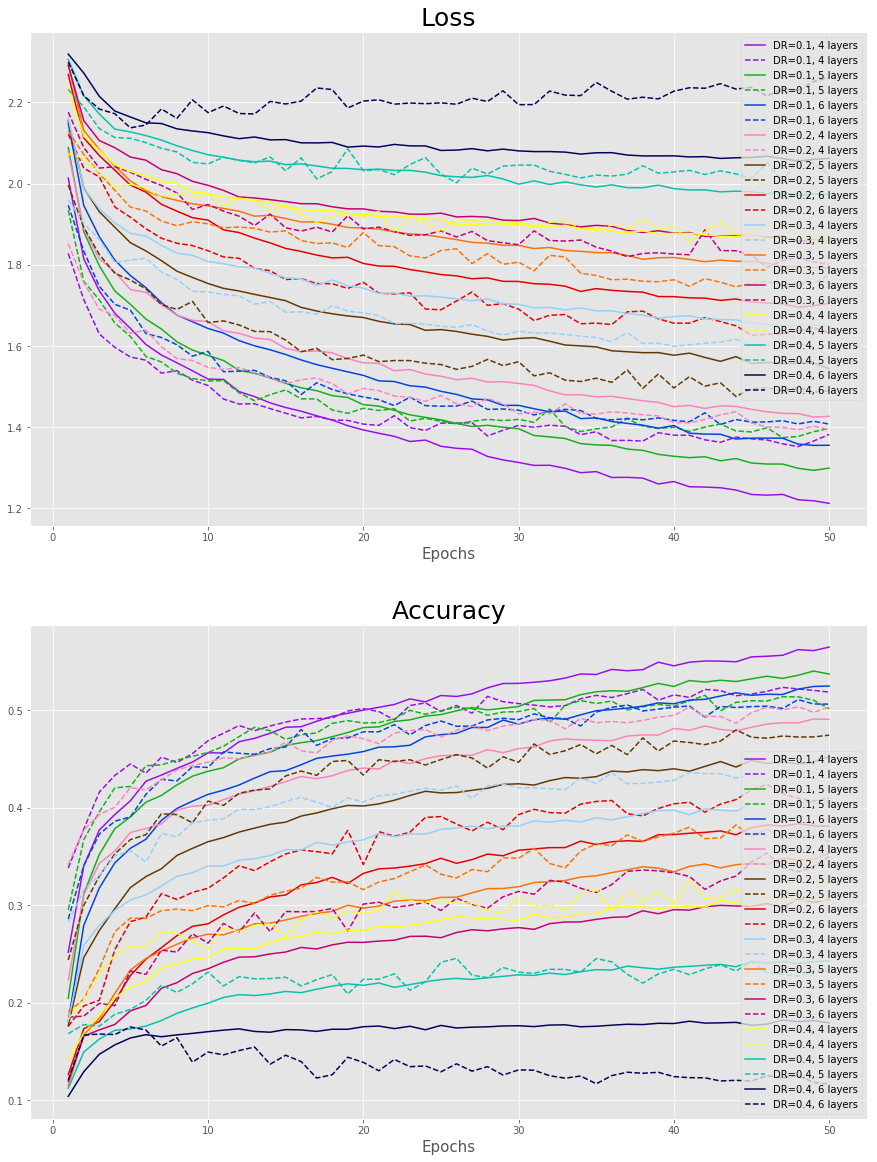

In [20]:
plotting(results)